# **КУРСОВАЯ РАБОТА**

## По дисциплине: 
## *"Фундаментальные и перспективные концепции искуственного интеллекта"*

# Введение
В качестве датасета был выбран датасет с информацией о пассажирах Титаника (всего доступно 891 запись о пассажирах)

Основные признаки, представленные в датасете:
* Survived (целевая переменная):

Указывает, выжил пассажир (1) или нет (0)
* Pclass:

Класс билета пассажира (1, 2, 3)

Является индикатором социально-экономического статуса пассажира
* Fare:

Стоимость билета, уплаченная пассажиром

Может свидетельствовать о классе обслуживания и доступных возможностях
* Sex:

Пол пассажира

Этот признак закодирован в бинарной форме (М = 1, Ж = 0)
* Age:

Возраст пассажира

Пропущенные значения заполняются медианным возрастом
* SibSp:

Количество братьев/сестер и супругов пассажира на борту

Позволяет оценить семейные связи
* Parch:

Количество родителей/детей пассажира на борту

В сочетании с SibSp помогает выявить пассажиров, путешествующих с семьей
* Embarked:

Порт посадки пассажира (C = Cherbourg, Q = Queenstown, S = Southampton)

Закодирован с использованием One-Hot Encoding (Embarked_C, Embarked_Q, Embarked_S)
* Name:

Имя пассажира (используется редко для анализа, но может содержать индикаторы статуса или пола), в данном случае использовать не будем
* PassengerId:

Уникальный идентификатор для каждого пассажира, использовать не будем
* Ticket:

Номер билета, в данном анализе не используется
* Cabin:

Номер каюты, часто содержит пропущенные данные, поэтому исключен из анализа



## Импортируем необходимые для работы библиотеки

In [1]:
import os
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy import stats

## Функция для установки и загрузки датасета

Файл скачивается с репозитория в гитхабе и сохраняется в среде Юпитера с именем titanic.csv

При загрузке файла очищаются данные (заполняет пропуски для возраста и портов) и удаляется столбец с каютами ввиду большого количества пропусков данных, также преобразуются категориальные переменные в дамми-переменные для удобства дальнейшей работы

In [2]:
def download_titanic_data():
    url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
    local_filename = "titanic.csv"
    if not os.path.exists(local_filename):
        print("Установка датасета...")
        response = requests.get(url)
        with open(local_filename, 'wb') as f:
            f.write(response.content)
        print(f"Датасет сохранен в {local_filename}")
    else:
        print("Датасет уже установлен локально")
    return local_filename

def load_titanic_data(local_filename):
    data = pd.read_csv(local_filename)
    data['Age'] = data['Age'].fillna(data['Age'].median())
    data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
    if 'Cabin' in data.columns:
        data = data.drop(columns=['Cabin'])
    categorical_feature_1 = ['Sex']
    data = pd.get_dummies(data, columns=categorical_feature_1, drop_first=True)
    categorical_feature_2 = ['Embarked']
    data = pd.get_dummies(data, columns=categorical_feature_2, drop_first=False)
    data['Sex'] = data['Sex_male'].apply(lambda x: 0 if x == 1 else 1)
    data = data.drop(columns=['Sex_male'])
    return data

local_filename = download_titanic_data()
data = load_titanic_data(local_filename)

Датасет уже установлен локально


Датасет уже присутствует локально на компьютере, в случае отсутсвия успешно скачается

# Анализ датасета

Сделаем предпросмотр датасета

In [3]:
print(data.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  38.0      1      0   
2                             Heikkinen, Miss. Laina  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  35.0      1      0   
4                           Allen, Mr. William Henry  35.0      0      0   

             Ticket     Fare  Embarked_C  Embarked_Q  Embarked_S  Sex  
0         A/5 21171   7.2500       False       False        True    0  
1          PC 17599  71.2833        True       False       False    1  
2  STON/O2. 3101282   7.9250       False       False        True    1  
3            113803  53.1000       Fal

Выведем сводную статистику по всем имеющимя столбцам

In [4]:
print(data.describe(include='all'))

        PassengerId    Survived      Pclass                 Name         Age  \
count    891.000000  891.000000  891.000000                  891  891.000000   
unique          NaN         NaN         NaN                  891         NaN   
top             NaN         NaN         NaN  Dooley, Mr. Patrick         NaN   
freq            NaN         NaN         NaN                    1         NaN   
mean     446.000000    0.383838    2.308642                  NaN   29.361582   
std      257.353842    0.486592    0.836071                  NaN   13.019697   
min        1.000000    0.000000    1.000000                  NaN    0.420000   
25%      223.500000    0.000000    2.000000                  NaN   22.000000   
50%      446.000000    0.000000    3.000000                  NaN   28.000000   
75%      668.500000    1.000000    3.000000                  NaN   35.000000   
max      891.000000    1.000000    3.000000                  NaN   80.000000   

             SibSp       Parch  Ticket 

Выведем количество недостающих данных в датасете (их не должно быть, потому что мы провели предобработку файла)

In [5]:
print(data.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
Sex            0
dtype: int64


In [6]:
record_size_bits = (data.memory_usage(deep=True).sum() / len(data)) * 8
print(f"Размер одной записи в битах: {record_size_bits:.2f} bits")
print(f"Количество записей: {len(data)}")
print(f"Количество полей: {len(data.columns)}")
print("Типы данных фичей:\n", data.dtypes)

Размер одной записи в битах: 1590.91 bits
Количество записей: 891
Количество полей: 13
Типы данных фичей:
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked_C        bool
Embarked_Q        bool
Embarked_S        bool
Sex              int64
dtype: object


Попробуем использовать датасет для визуализации выживаемости пассажиров в зависимости от класса пассажира

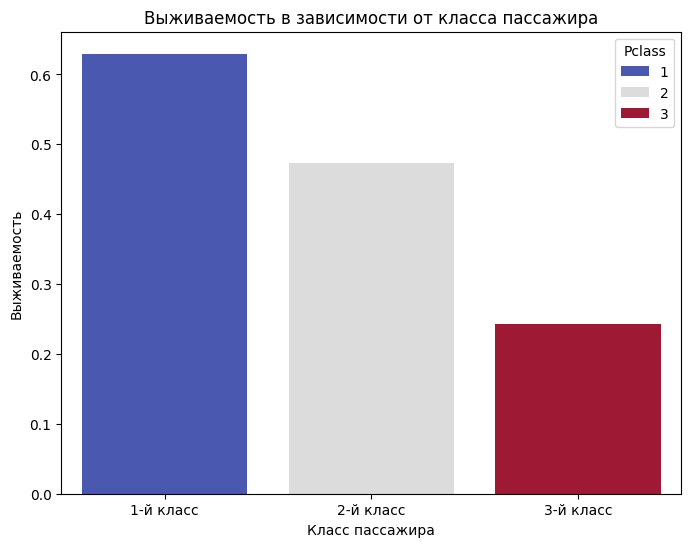

In [7]:
survival_rate_by_class = data.groupby('Pclass')['Survived'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='Pclass', y='Survived', data=survival_rate_by_class, hue='Pclass', dodge=False, palette='coolwarm')
plt.title('Выживаемость в зависимости от класса пассажира')
plt.xlabel('Класс пассажира')
plt.ylabel('Выживаемость')
plt.xticks(ticks=[0, 1, 2], labels=['1-й класс', '2-й класс', '3-й класс'])
plt.show()

Построим корреляционную матрицу для числовых данных с целью выявления аналитических зависимостей между признаками

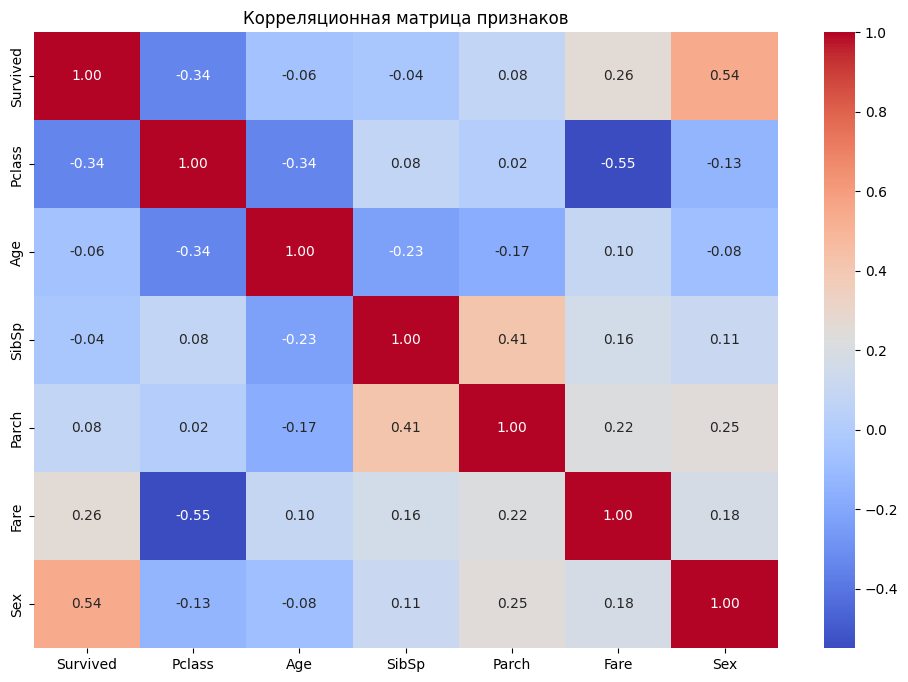

In [8]:
numeric_data = data.select_dtypes(include=[np.number])
numeric_data = numeric_data.drop(columns=['PassengerId'], errors='ignore')
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Корреляционная матрица признаков')
plt.show()

# Применение алгоритма машинного обучения на датасете

Попробуем построить модель предсказания выживаемости пассажира на основе имеющихся признаков для решения задачи бинарной классификации

Целевая переменная выживаемости может иметь только два значения (1 - выжил, 0 - нет)

Из признаков удалены ненужные в данной модели и содержащие текстовые данные

In [9]:
X = data.drop(columns=['Survived', 'Name', 'Ticket', 'PassengerId'])
y = data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Для обучения воспользуемся моделью случайного лесного классификатора из библиотеки Sklearn с 100 деревьями на заданных тренировочных данных

In [10]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Оценим важность признаков для модели случайного лесного классификатора

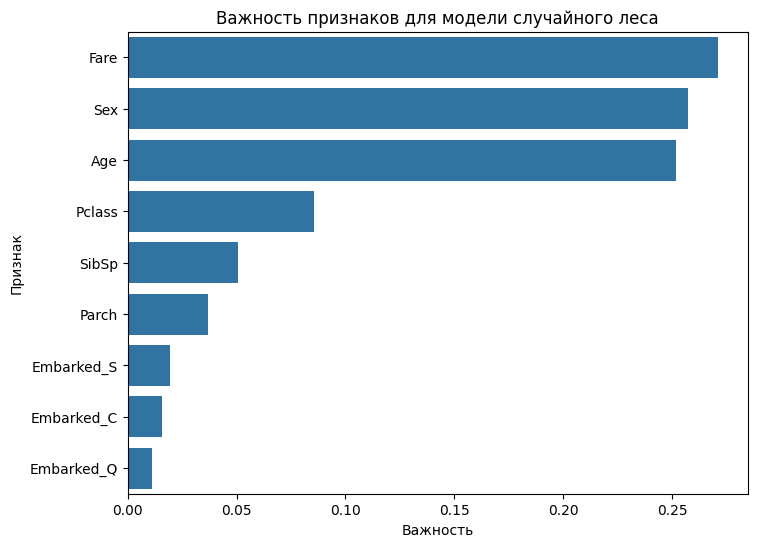

In [11]:
feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Признак': features, 'Важность': feature_importances})
importance_df = importance_df.sort_values(by='Важность', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Важность', y='Признак', data=importance_df)
plt.title('Важность признаков для модели случайного леса')
plt.show()

Мы выявили, что наиболее важными параметрами для предсказания на модели случайного леса выживаемости являются:
* Уровень дохода
* Возраст
* Пол

Казалось бы, между возрастом и выживаемостью крайне низкая корреляция, однако в модели случайного леса важность параметров определяется их вкладом в уменьшение энтропии при разделении данных для предсказания, возраст имеет нелинейные зависимости, например, взрослые и пожилые пассажиры могли иметь разные шансы на спасение в зависимости от класса обслуживания и других факторов, что отразилось в наличии скрытых закономерностей, которые сразу могут и не броситься в глаза, поэтому в данном случае и применяется машинное обучение

Выведем значения метрик, показывающих успешность машинного обучения:
* Accuracy
* Precision
* Recall
* F1-score

In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       157
           1       0.73      0.71      0.72       111

    accuracy                           0.77       268
   macro avg       0.77      0.76      0.76       268
weighted avg       0.77      0.77      0.77       268



Мы видим, что точность модели составляет ~77%

# Понижение размерности и кластеризация

Для понижения размерности используем метод главных компонент PCA (Principal Component Analysis), чтобы уменьшить исходный набор фич до двух главных компонент с сохранением структуры данных

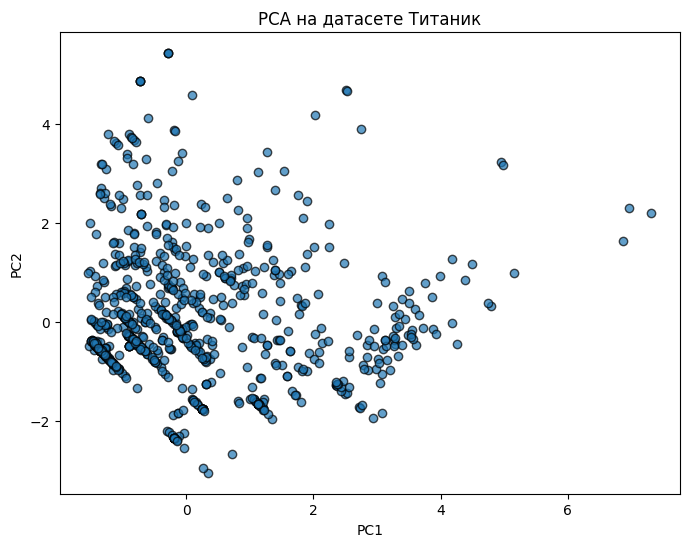

In [19]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7, edgecolor='black')
plt.title('PCA на датасете Титаник')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Для кластеризации данных применим метод k-средних как наиболее популярный

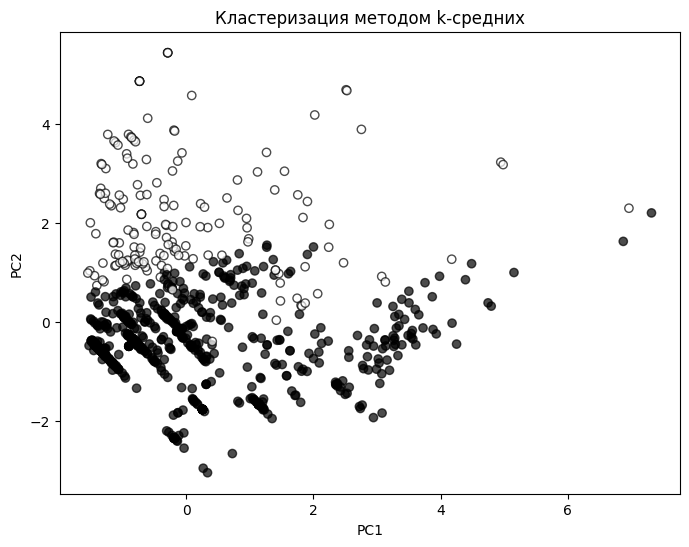

In [24]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='Greys', alpha=0.7, edgecolor='black')
plt.title('Кластеризация методом k-средних')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Метод разбил данные на два кластера по таргету, при этом мы не можем видеть четкой картины разделения данных ввиду высокой энтропии данных при наличии размытых, порой случайных взаимосвязей между фичами

Это объясняется хаосом, который происходил во время крушения корабля, вдобавок к этому, мы не можем на сто процентов гарантировать достоверность правдивости данных, поскольку многие пассажиры пропали без вести, и их судьба неизвестна

# Выбросы

Для поиска выбросов данных применим один статистический метод и метод машинного обучения

В качестве метода машинного обучения используем изоляционный лес из библиотеки Sklearn для поиска выбросов данных

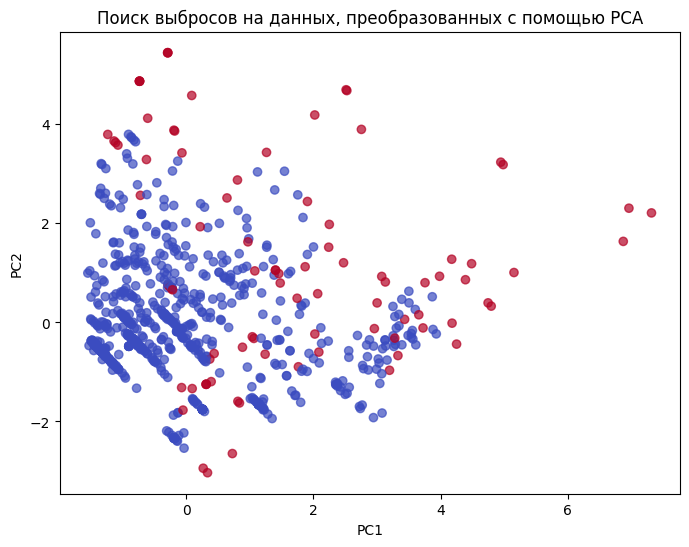

In [28]:
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
outliers = isolation_forest.fit_predict(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=outliers, cmap='coolwarm_r', alpha=0.7)
plt.title('Поиск выбросов на данных, преобразованных с помощью PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Используя данный метод, мы получили довольно внушительное количество выбросов: основная часть рассредоточена по точкам, сильно выдающимся от основной "кучи", и несколько точек ближе к центру данных

Такое количество выбросов может быть обусловлено порой сильно завышенной фичей Fare в части данных, фичей Age в случае очень маленьких детей и пожилых людей

В качестве статистического метода применим Z-оценку выбросов, но по исходному набору данных

In [16]:
numeric_columns = data.select_dtypes(include=[np.number]).drop(columns=['PassengerId'])
z_scores = np.abs(stats.zscore(numeric_columns))
outliers_zscore = (z_scores > 3).sum(axis=0)
print(outliers_zscore)

Survived     0
Pclass       0
Age          7
SibSp       30
Parch       15
Fare        20
Sex          0
dtype: int64


Z-оценка в явном виде предоставила количество выбросов по числовым признакам, причем здесь так же присутствуют выбросы по фичам SibSp и Parch

Это можно объяснить тем, что далеко не все пассажиры путешествовали с семьями, а у некоторых семья была очень большой, особенно в первом классе пассажиров, что составляет меньшую часть выборки и могло быть причислено к выбросам

# ML System Design

Наша модель может быть адаптирована для прогнозирования вероятности успешного завершения операции, спасения или минимизации рисков в ситуациях, связанных с чрезвычайными происшествиями, может помочь выявлять группы риска

Так же модель применима при проектировании транспортных средств высокой пассажировместимости после анализа групп риска для повышения потенциальной выживаемости в аварийных ситуациях

Однако модель не лишена недостатков: она требует адаптации под различные ситуации (крушение Татиника это лишь один из примеров ЧС, и в каждой ситуации будет уникальной набор признаков), а в системе признаков существует хаос, который практически невозможно оценить из-за человечского и моральных аспектов

Тему выделения групп риска можно дополнить, например, методы кластеризации для данного датасета могут быть применены для разделения пассажиров по предпочтениям к поездке (сколько денег готовы заплатить, какой хотят класс обслуживания и рассортировать их, например, по возрасту). Это можно использовать для создания уникальных рекламных предложений, что может быть актуально для операторов перевозок, например, авиакомпаниям

# Выводы

В данной курсовой работе мы научились работать с датасетами, анализировать данные в нем и использовать на нем алгоритмы машинного обучения

На примере датасета Титаник мы обучили на тестовых данных модель, прогнозирующую вероятность выживания пассажиров, точность модели составила 77%, используя случайный лесной классификатор 

Мы попробовали использовать методы понижения размерности и кластеризации на нашем датасете:
* Метод PCA для понижения размерности до двух главных компонент
* Метод K - средних для разбиения данных на два кластера

Проанализировали так же и выбросы, использовав, использовав два различных метода для их поиска:
* Метод изоляционного леса в качестве метода машинного обучения для данных, обработанных PCA методом
* Z - оценку в качестве статистического, получив четкую оценку выбросов для разных фич

В работе мы проанализировали применимость нашей модели в различных продакшн-системах:
* В качестве модели предсказания успешности каких-либо действий при ЧС
* Для сервисов пассажирских перевозок на основе данных о клиентах
* Для таргентированной рекламы
* При проектировании ТС большой пассажировместимости